In [1]:
from fastai2.vision.all import *
from siren import siren_model

In [82]:
#Helper function
def decode_prediction(learner, inp, size=256):
    y_hat = learn.model(inp.cuda())
    return TensorImage(y_hat.transpose(0, 1).reshape(3, size, size))

# SuperResolution

This time, i'll try to fit the image, then evaluate the model at a higher resolution than the original and compare.

Inspired to try by this comment:

https://forums.fast.ai/t/siren-sinusoidal-representation-networks/73663/6

# Visualizing the original image

In [3]:
pipe = Pipeline([PILImage.create, ToTensor, IntToFloatTensor, Resize(256)])
image = pipe("Samples/yorkshire_terrier_9.jpg")

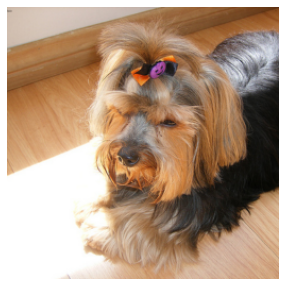

In [4]:
image.show();

# Preparing the dataset

The first step is to reshape the image, so that each pixel will be a training example

In [7]:
y = image.reshape(3, -1).transpose(0, 1)
y.shape

torch.Size([65536, 3])

Then we create the coordinates that will be the input. According to the paper, they should be in the range [-1, 1], so we use meshgrid to create the coordinate pair (u, v) easily. In this case, the point (0, 0) represents the center of the image.

In [8]:
g0, g1 = torch.meshgrid([torch.arange(-1, 1, step=2/256), torch.arange(-1, 1, step=2/256)])
x = torch.cat([g0.flatten().unsqueeze(1), g1.flatten().unsqueeze(1)], dim=1)
x = x.float()
x.shape

torch.Size([65536, 2])

Performing a quick check to make sure that the coordinates are correct

In [9]:
for coord, pixel_value in zip(x, y):
    c = ( 128 * (1 + coord)).long()
    assert (image[:, c[0], c[1]] == pixel_value).all(), "Pixel values do not match"

Now creating the dataset (image coordinates) -> (image pixel)

In [10]:
from torch.utils.data import TensorDataset, random_split
dset = TensorDataset(x.cuda(), y.cuda())

Training with 95% of the pixels.

In [46]:
val_pct = 0.05
val_len = int(len(dset)*val_pct)
lengths = [len(dset)-val_len, val_len]
train_dset, val_dset = random_split(dset, lengths)

In [47]:
dls = DataLoaders(DataLoader(train_dset, bs=256), DataLoader(val_dset, bs=4096))

# Creating the model, optimizer and loss

In [48]:
learn = Learner(dls, 
    siren_model([2, 256, 128, 64, 32, 3]).cuda(), 
    loss_func=MSELossFlat(),
    opt_func=ranger
    )

In [81]:
learn.model

Sequential(
  (0): Sequential(
    (0): Linear(in_features=2, out_features=256, bias=True)
    (1): Siren(w0=30)
  )
  (1): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): Siren(w0=1)
  )
  (2): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): Siren(w0=1)
  )
  (3): Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): Siren(w0=1)
  )
  (4): Sequential(
    (0): Linear(in_features=32, out_features=3, bias=True)
    (1): Siren(w0=1)
  )
)

# Starting the training

In [49]:
learn.fit_flat_cos(300, lr=1e-3)

epoch,train_loss,valid_loss,time
0,0.118730,0.072471,00:01
1,0.024406,0.019462,00:01
2,0.008719,0.007977,00:01
3,0.004614,0.004818,00:01
4,0.003187,0.003400,00:01
5,0.002532,0.002720,00:01
6,0.002162,0.002534,00:01
7,0.001913,0.002177,00:01
8,0.001755,0.001947,00:01
9,0.001631,0.001989,00:01


Evaluating the image at the original resulution

In [76]:
decoded = decode_prediction(learn, x, siz)

Evaluating the image at a upsampled resolution

In [51]:
resol = 512 # Resolution
g0, g1 = torch.meshgrid([torch.arange(-1, 1, step=2/resol), torch.arange(-1, 1, step=2/resol)])
x_upsample = torch.cat([g0.flatten().unsqueeze(1), g1.flatten().unsqueeze(1)], dim=1)
x_upsample = x_upsample.float()

In [79]:
upsampled = decode_prediction(learn, x_upsample, size=512)

Notice the smoother details, specially while looking near the nose region

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


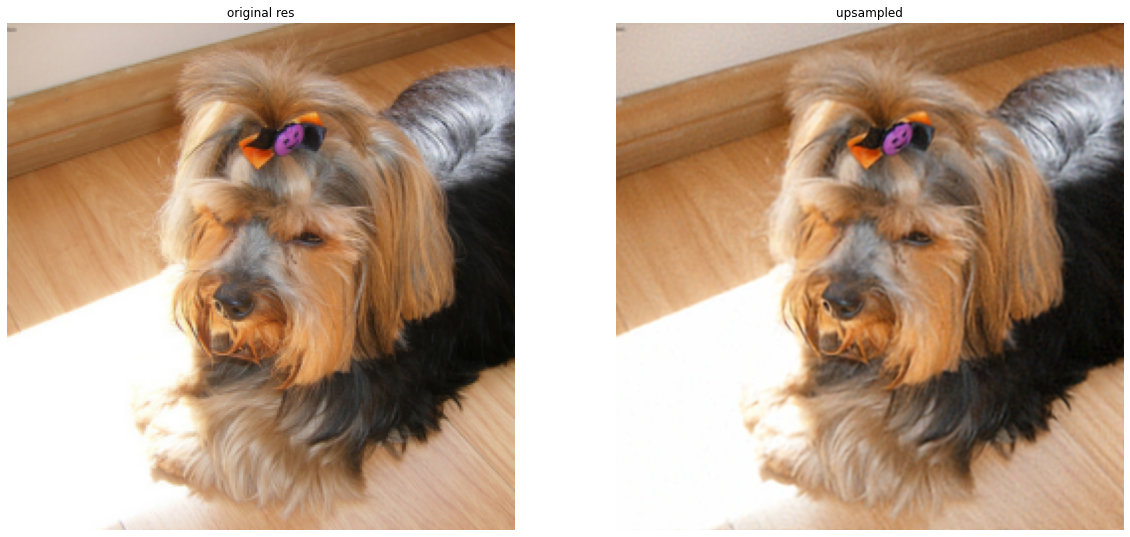

In [80]:
_, ax = subplots(1, 2, figsize=(20, 30))
image.show(ax[0], title='original res')
upsampled.show(ax[1], title='upsampled')

If you want to compare the original image, the learned representation and the upsampled version, run the following cell to save the three images to disk

In [ ]:
from torchvision.utils import save_image

save_image(image, 'original.png')
save_image(decoded, 'decoded.png')
save_image(upsampled, 'upsampled.png')